In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Week 1 work
start_date = '1985-01-01'
end_date = '1989-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
1985-01-01,179.630005,180.270004,163.360001,167.199997,2673710000
1985-02-01,181.179993,183.949997,177.750000,179.630005,2194620000
1985-03-01,180.660004,183.889999,176.529999,181.179993,2153090000
1985-04-01,179.830002,183.610001,177.860001,180.660004,1981880000
1985-05-01,189.550003,189.979996,178.350006,179.830002,2350340000


In [4]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

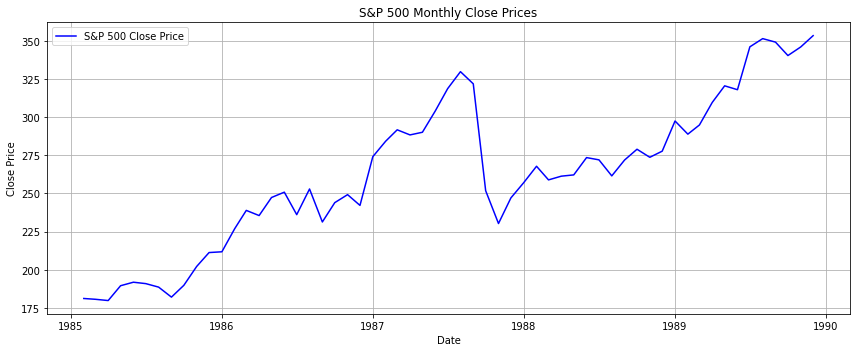

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

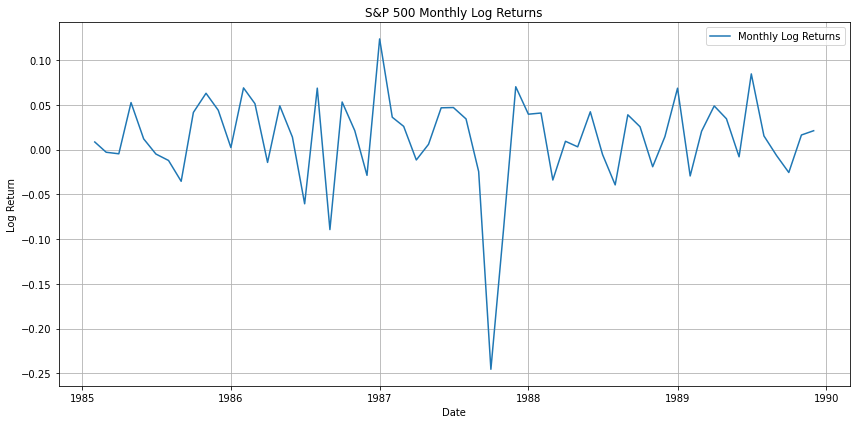

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

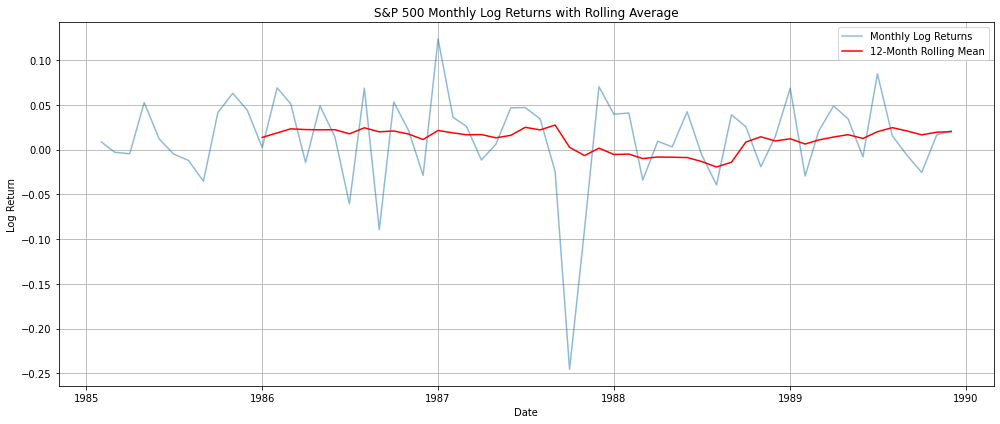

In [7]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

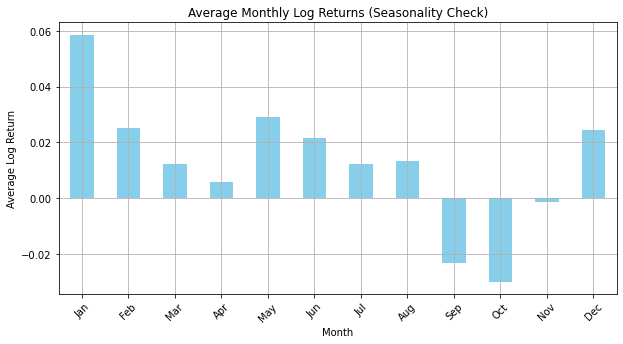

In [8]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

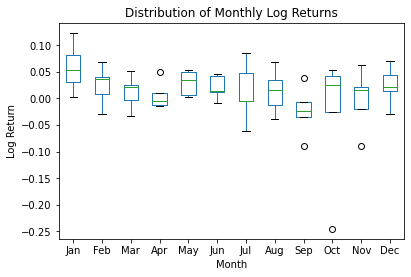

In [9]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [10]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -6.845243
p-value: 0.000000
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


**Analysis:**

The Augmented Dickey-Fuller (ADF) test confirms that the log return series is stationary, with an ADF statistic of -6.845 and a p-value effectively equal to 0. 

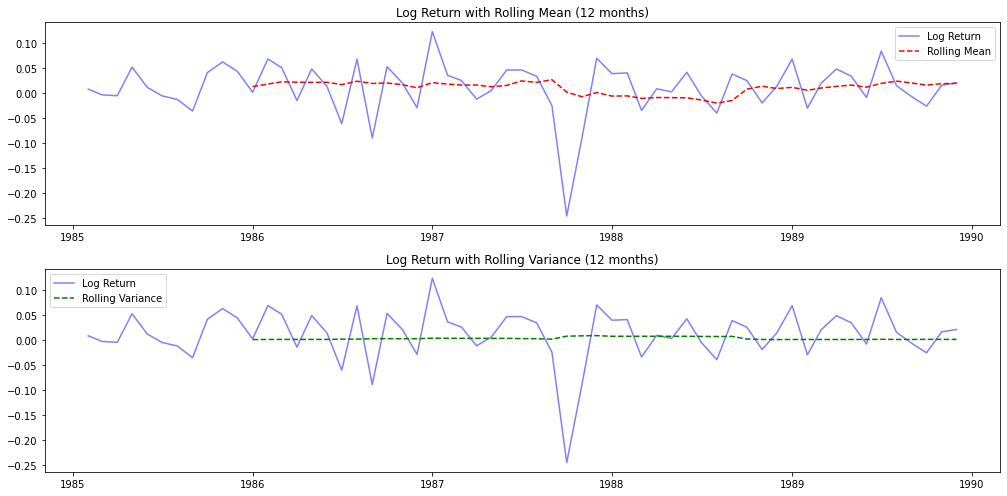

In [11]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

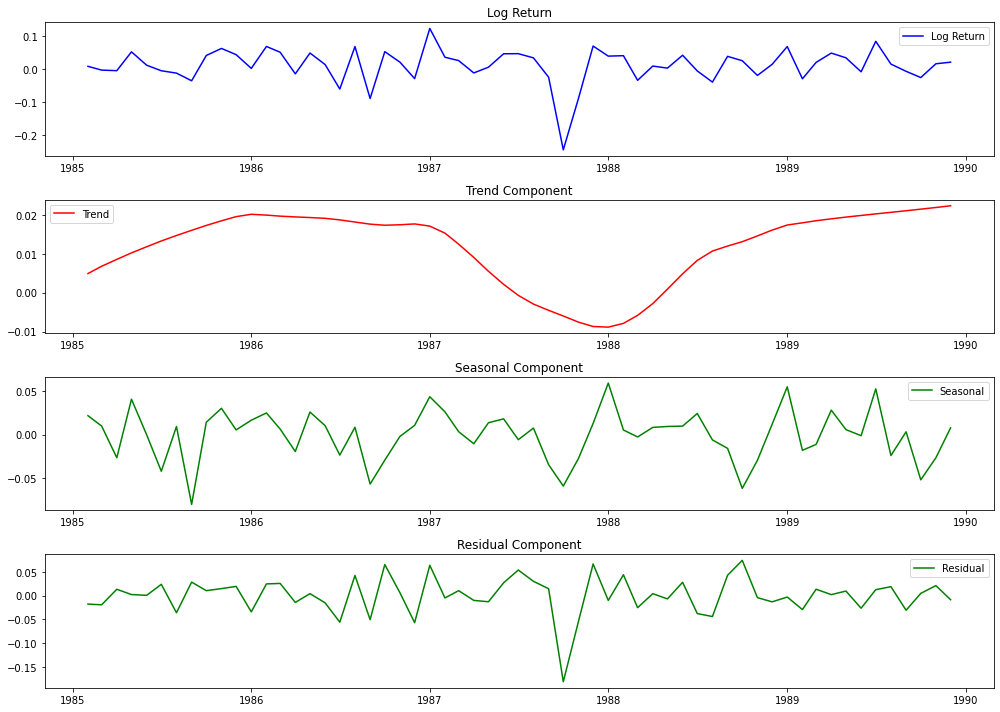

In [12]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                   59
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  92.267
Date:                Sun, 27 Apr 2025   AIC                           -176.533
Time:                        19:49:26   BIC                           -168.223
Sample:                    02-01-1985   HQIC                          -173.289
                         - 12-01-1989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113      0.009      1.220      0.222      -0.007       0.029
ar.L1         -0.8194      0.140     -5.858      0.000      -1.094      -0.545
ma.L1          0.9997     13.90

**Analysis:**

The AR(1) coefficient of -0.8194 indicates strong mean-reverting behavior, meaning that if the value of the time series (e.g., stock returns) is above the average in one period, it is likely to decrease in the next period, and vice versa. This suggests that returns tend to fluctuate around a central value, correcting themselves over time.

In terms of the January/November effect, mean-reverting behavior implies that significant movements in returns during these months are likely to be followed by corrections. For example, if returns are high in January due to seasonal factors, a mean-reverting model would predict a potential decline or stabilization in December or the following months.

However, the residuals' non-normality and skewness (indicating large fluctuations or outliers) suggest that the model doesn't fully capture all the characteristics of the data. This could mean that the January/November effect is influenced by factors outside the model's scope, such as unexpected market events or shifts in investor sentiment, which could lead to larger-than-expected movements in returns.

In [14]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52319D+00    |proj g|=  1.08863D+00

At iterate    5    f= -1.52480D+00    |proj g|=  6.77109D-01

At iterate   10    f= -1.52758D+00    |proj g|=  7.42726D-02

At iterate   15    f= -1.52803D+00    |proj g|=  1.19817D-01

At iterate   20    f= -1.53959D+00    |proj g|=  9.13670D-02

At iterate   25    f= -1.54087D+00    |proj g|=  4.25701D-01

At iterate   30    f= -1.54270D+00    |proj g|=  1.00916D-01

At iterate   35    f= -1.54329D+00    |proj g|=  2.32780D-02

At iterate   40    f= -1.54496D+00    |proj g|=  1.85227D-01

At iterate   45    f= -1.54615D+00    |proj g|=  7.22422D-02

At iterate   50    f= -1.54673D+00    |proj g|=  1.06326D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

**Analysis:**

The SARIMA(1,0,1)x(1,0,1,12) model shows a moderate negative correlation between current and previous values, with the AR(1) coefficient being statistically significant. However, the MA(1), seasonal AR, and seasonal MA terms are not significant, suggesting that the seasonal components don’t capture meaningful patterns. The model's error variance is poorly estimated, and the residuals are not normally distributed, showing negative skew and heavy tails. While the model fits the autocorrelation structure well, it struggles with residual behavior.

In [15]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.9166
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.533
Time:                        19:54:48   Log-Likelihood:                 96.194
No. Observations:                  59   AIC:                            -168.4
Df Residuals:                      47   BIC:                            -143.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

The OLS regression with monthly dummies highlights significant differences in log returns for certain months compared to the baseline of January. November shows a statistically significant negative coefficient (-0.0820, p-value = 0.026), indicating that returns in November are significantly lower than in January. October also shows a significant negative coefficient (-0.0887, p-value = 0.016), reflecting even lower returns than in November. Additionally, September approaches significance with a coefficient of -0.0601 (p-value = 0.098), hinting at potentially weaker returns, though it doesn’t reach the typical threshold for statistical significance. Other months, such as February through August, do not show significant differences from January, suggesting that the most notable seasonal effects occur in October and November, where returns tend to be lower compared to the start of the year.

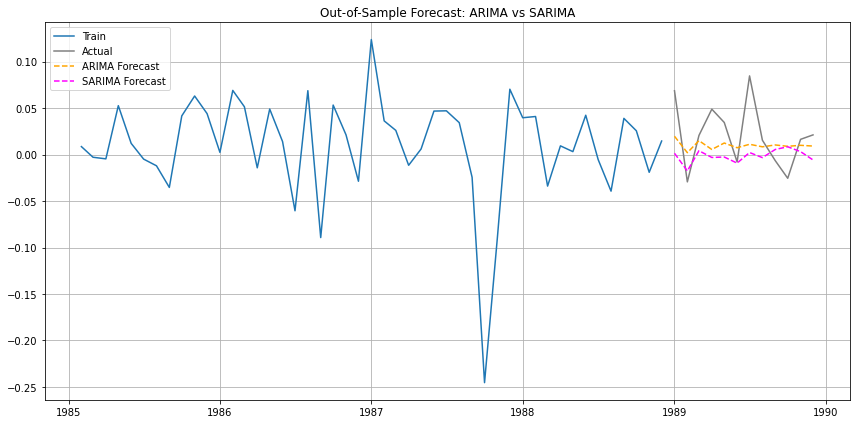

In [21]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

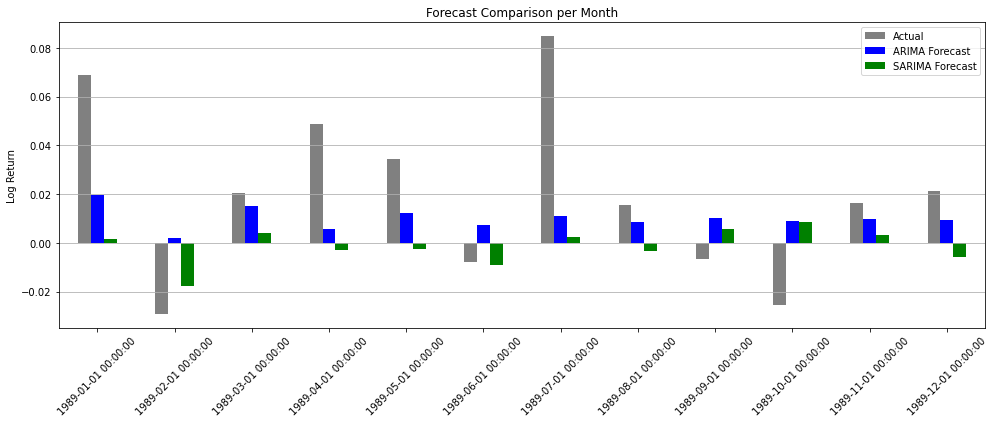

In [17]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

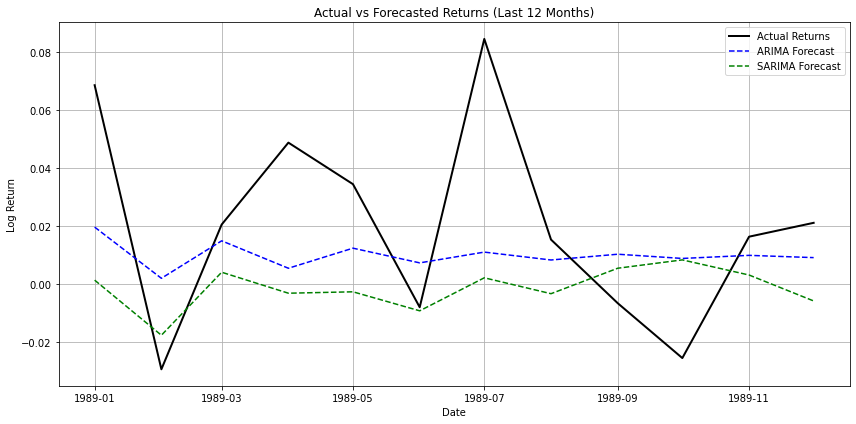

In [18]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.02643
ARIMA RMSE: 0.03309

SARIMA MAE: 0.03110
SARIMA RMSE: 0.03913


**Analysis:**

The ARIMA model shows better forecasting accuracy than the SARIMA model, with a lower MAE (0.02643 vs. 0.03110) and RMSE (0.03309 vs. 0.03913), indicating more precise predictions over the last 12 months.

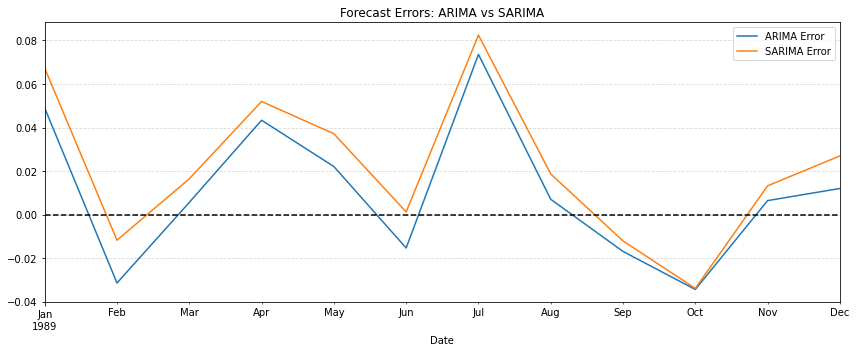

In [20]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()